# 3D non-linear System

###Dynamics
$$   \boldsymbol {\dot x} =f(\boldsymbol{x},\boldsymbol{u}) = f(\boldsymbol x)+g(\boldsymbol x)\boldsymbol u $$

###Optimal Control problem (finite horizon with terminal cost): 
$$\min_{u} \mathcal{L} = \boldsymbol x(t_f)^T \boldsymbol M \boldsymbol x(t_f) + \int_{0}^{t_f}(\boldsymbol x^T\boldsymbol Q \boldsymbol x+\boldsymbol u^T\boldsymbol R \boldsymbol u )dt \quad\text{   where  } \quad t_f=1 $$

### HJB equation:
$$ V_t = \sup_\boldsymbol u -H(\boldsymbol x,V_x, \boldsymbol u,t) = \sup_\boldsymbol u \{-(\nabla_\boldsymbol x V)^Tf(\boldsymbol x,\boldsymbol u) - \boldsymbol x^T\boldsymbol Q \boldsymbol x-\boldsymbol u^T\boldsymbol R \boldsymbol u \} $$

$$ \boldsymbol u_{opt} = -\frac{1}{2}\boldsymbol R^{-1} g^T(\boldsymbol x)\nabla_\boldsymbol x V$$

### Resulting PDE to solve:
$$-V_t- \boldsymbol x^T\boldsymbol Q \boldsymbol x + \frac{1}{4}(\nabla_\boldsymbol x V)^T g(\boldsymbol x)\boldsymbol R^{-1} g^T(\boldsymbol x)(\nabla_\boldsymbol x V) = 0 \quad 
\text{s.t: } V(1,\boldsymbol x) = \boldsymbol x^T M \boldsymbol x \quad $$




 ## Load packages, class definition, and cost intialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from os.path import exists
import math
from tqdm import tqdm

In [2]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=3):
        super().__init__()
        
        self.layer_first = nn.Linear(4, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1)
        
    def forward(self, x):
        activation = nn.SiLU()
        u = activation(self.layer_first(x))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

In [3]:
mse_loss = nn.MSELoss()

q = 6 # Q = qI
r = 0.5 # R = rI
m= 3 # M = mI

## Model Training


In [ ]:
t1d=torch.linspace(0,1,25,requires_grad=True)
x1d=torch.linspace(-1,1,25,requires_grad=True)
y1d=torch.linspace(-1,1,25,requires_grad=True)
th1d=torch.linspace(-3.141,3.141,25,requires_grad=True)

tgrid, xgrid, ygrid, thgrid = torch.meshgrid(t1d, x1d, y1d, th1d, indexing ='ij')

t=tgrid.flatten().unsqueeze(-1)
x=xgrid.flatten().unsqueeze(-1)
y=ygrid.flatten().unsqueeze(-1)
th=thgrid.flatten().unsqueeze(-1)

in_vec = torch.hstack((t,x,y,th))
t_bou = torch.ones((in_vec.shape[0],1),requires_grad=True)

# 2. set the model
torch.manual_seed(23939)
model = ffnn(15, 3)
loss_history = []

if  exists('diff_drive_mod.pth'):
  print("model loaded successfully")
  model.load_state_dict(torch.load('diff_drive_mod.pth'))
  loss_history = torch.load('loss_history.pt')

model= nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

s_mu = torch.tensor(0.0, requires_grad= False, device= device)
s_sig = torch.tensor(0.0, requires_grad= False, device= device)

learnable_param = list(model.parameters()) #+[ s_sig, s_mu]




In [ ]:
# 3. set the optimizer
lr = 0.0001
n_epochs = 70000
opt = torch.optim.Adam(learnable_param, lr)

in_vec = in_vec.to(device)
t_bou = t_bou.to(device)
model = model.to(device)
device

In [ ]:
def loss_function(model, in_vec,t_bou):
  v=model(in_vec)*torch.exp(s_sig) + s_mu
  v_x_1= model(torch.hstack((t_bou,in_vec[:,1:])))*torch.exp(s_sig) + s_mu

  loss_v_1= mse_loss(v_x_1, m*torch.sum(torch.square(in_vec[:,1:]),axis =1).unsqueeze(-1))
  
  v_X = torch.autograd.grad(v, in_vec,grad_outputs=t_bou,retain_graph=True,create_graph=True)[0]

  resid= -v_X[:,0].view(-1,1) - \
          q*torch.sum(torch.square(in_vec[:,1:]),axis =1).view(-1,1) + \
          1/r*0.25* torch.square(v_X[:,1].view(-1,1)*torch.cos(in_vec[:,3]).view(-1,1) + \
          v_X[:,2].view(-1,1)*torch.sin(in_vec[:,3]).view(-1,1) ) + \
          1/r*0.25 *torch.square(v_X[:,3].view(-1,1))
  loss_r = (resid**2).mean()
  loss_value =  loss_r + loss_v_1  #+ 1/(s_sig+0.0001)**2
  #print(loss_v_1.item(), loss_r.item())
  return loss_value

In [ ]:
print(s_sig.item(), s_mu.item())

In [ ]:

for i in tqdm(range(n_epochs)):
  loss=loss_function(model, in_vec, t_bou)
  opt.zero_grad()
  loss_history.append(loss.item())
  loss.backward()
  opt.step()
  if i % 1000 == 0:
    print(f'epoch {i}, loss = {loss}')

In [ ]:
torch.save(model.module.state_dict(), "diff_drive_mod.pth")
torch.save(loss_history, "loss_history.pt")

In [ ]:
loss

## Evaluate the solution

In [4]:
model = ffnn(15, 3)
model.load_state_dict(torch.load('diff_drive_mod.pth',map_location='cpu'))
model.eval()
loss_history = torch.load('loss_history_1.pt')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


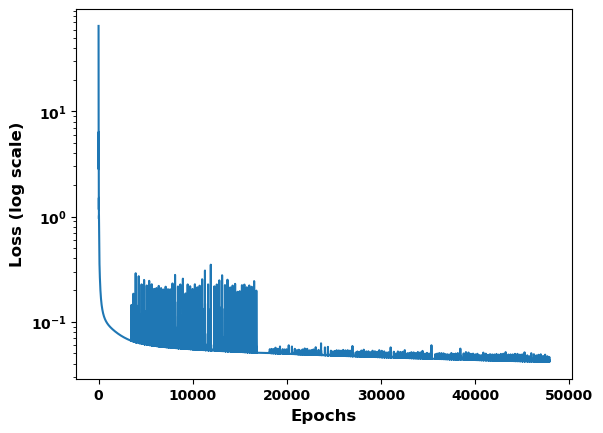

In [5]:
import matplotlib 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots()
ax.plot(loss_history, )
ax.set_xlabel('Epochs', fontsize=12, fontweight = 'bold')
ax.set_ylabel('Loss (log scale)', fontsize=12, fontweight = 'bold');
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.savefig("loss_differential drive.png",bbox_inches ="tight", dpi = 200)
    

In [46]:
def u(model,x):
  ######## x is N=1
  v=model(x)
  temp = torch.ones((x.shape[0],1),requires_grad=True)
  v_x = torch.autograd.grad(v,x,grad_outputs=temp,retain_graph=True,create_graph=True)[0]
  v_x = v_x[:,1:]
  u = v_x[:,0]*torch.cos(x[:,3])+ v_x[:,1]*torch.sin(x[:,3])
  u =torch.hstack((u,v_x[:,2]))


  return -0.5*(1/r)*u.t()


In [59]:
import time
start = time.time()
x_init= torch.tensor([1.0,0, 3.141],requires_grad=True).unsqueeze(-1)
#x_init= torch.tensor([-0.03511038,  0.2685325 ,  0.01412083],requires_grad=True).unsqueeze(-1)
t1d=torch.linspace(0,1,50,requires_grad=True)

x=x_init
states=[x.detach().numpy().squeeze()]
controls =[]
dt = (t1d[1]-t1d[0]).detach()
for t in t1d:
  in_vec = torch.vstack((t.view(1,1),x)).t()
  u_opt = u(model, in_vec )
  del_x=  torch.tensor([[torch.cos(x[2]),0],[torch.sin(x[2]),0],[0,1]]) @ u_opt
  del_x = del_x.view(x.shape)
  x=x + del_x*dt
  states.append(x.detach().numpy().squeeze())
  controls.append(u_opt.detach().numpy().squeeze())

end = time.time()

In [60]:
tot_time = end - start
print(tot_time)

0.050232648849487305


In [48]:
states = np.asarray(states)
controls = np.asarray(controls)
t1d=t1d.requires_grad_(requires_grad=False).numpy()
t1d = np.append(t1d,t1d[-1])

controls = np.vstack((controls, np.array([0,0])))
controls.shape

(501, 2)

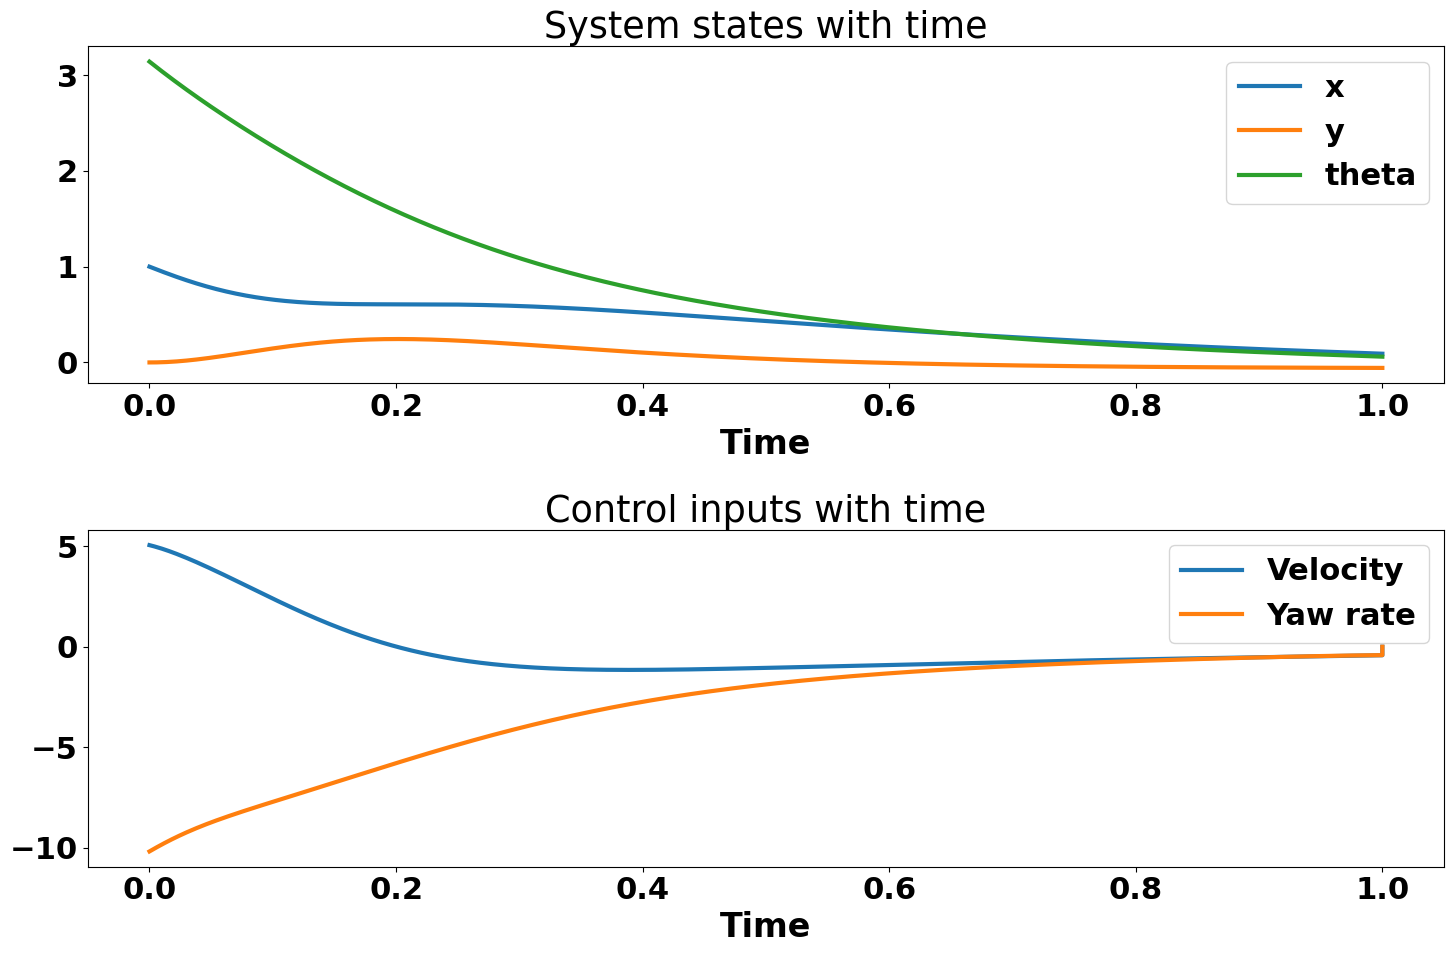

In [49]:
font = { 'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
#plt.clf()
plt.plot(t1d, states[:,0],  linewidth=3)
plt.plot(t1d, states[:,1], linewidth=3)
plt.plot(t1d, states[:,2], linewidth=3)
plt.title('System states with time')
plt.xlabel('Time', fontsize=24, fontweight = 'bold')
plt.legend(['x','y','theta'])
#plt.savefig("Canvas12.png",dpi=500)

plt.subplot(2, 1, 2)
#plt.clf()
plt.plot(t1d, controls[:,0], linewidth=3)
plt.plot(t1d, controls[:,1], linewidth=3)
plt.xlabel('Time', fontsize=24, fontweight = 'bold')
plt.title('Control inputs with time')
plt.legend(['Velocity','Yaw rate'])
#plt.savefig("Canvas13.png",dpi=500)

plt.tight_layout()
plt.savefig("traj_2.png", dpi = 200)

plt.show()

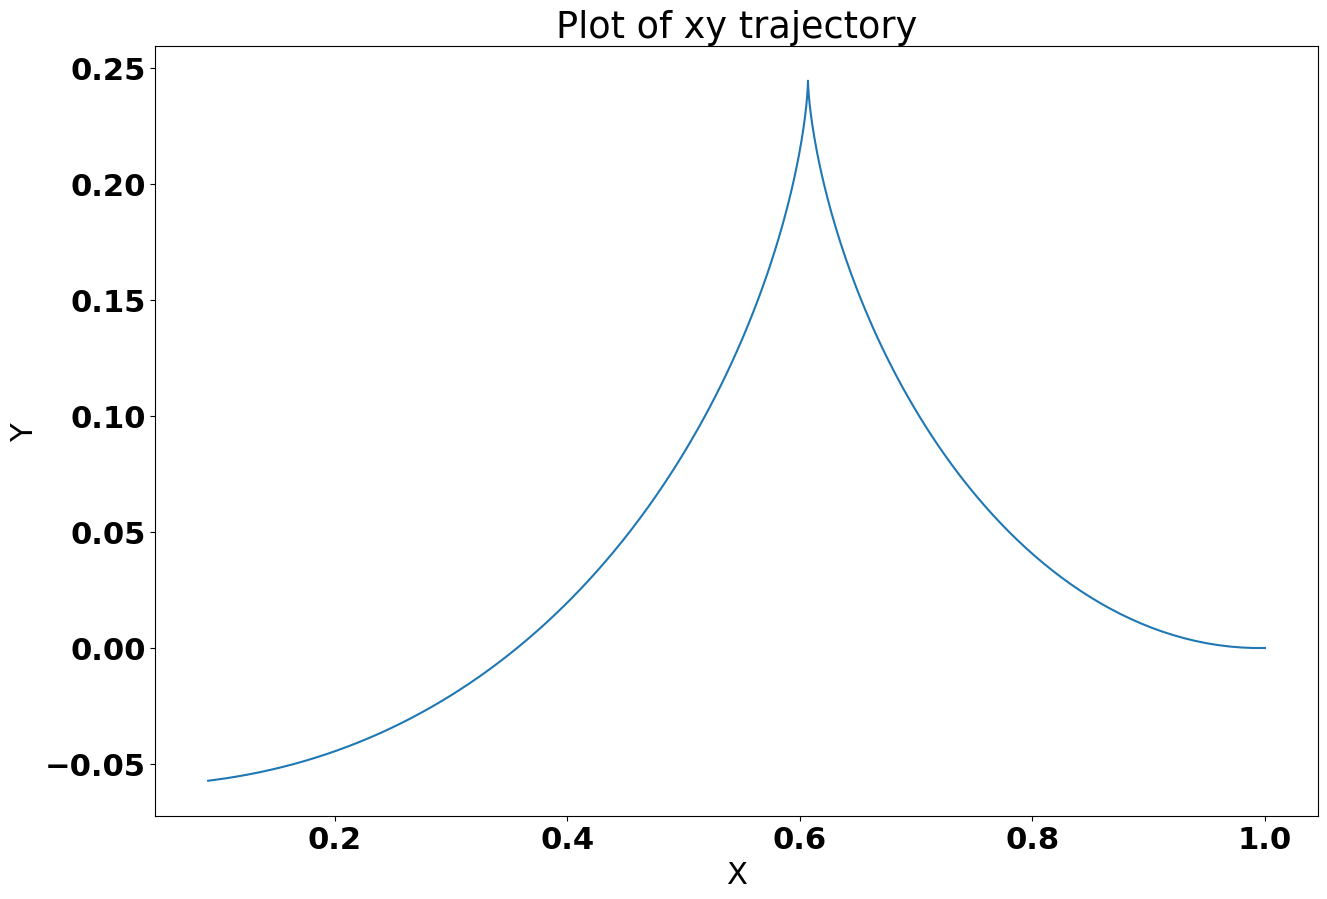

In [50]:
plt.figure(figsize=(15,10))
plt.plot(states[:,0],states[:,1])
plt.title('Plot of xy trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [11]:
import os

path = os.getcwd()
parent = os.path.dirname(path)
filename = parent+ '/sample_state_trajectories' +'/trajec_3_round_at_x_1_500hz.npy'
np.save(filename, states)

In [12]:
tot_time = end - start
print(tot_time)

0.5343234539031982


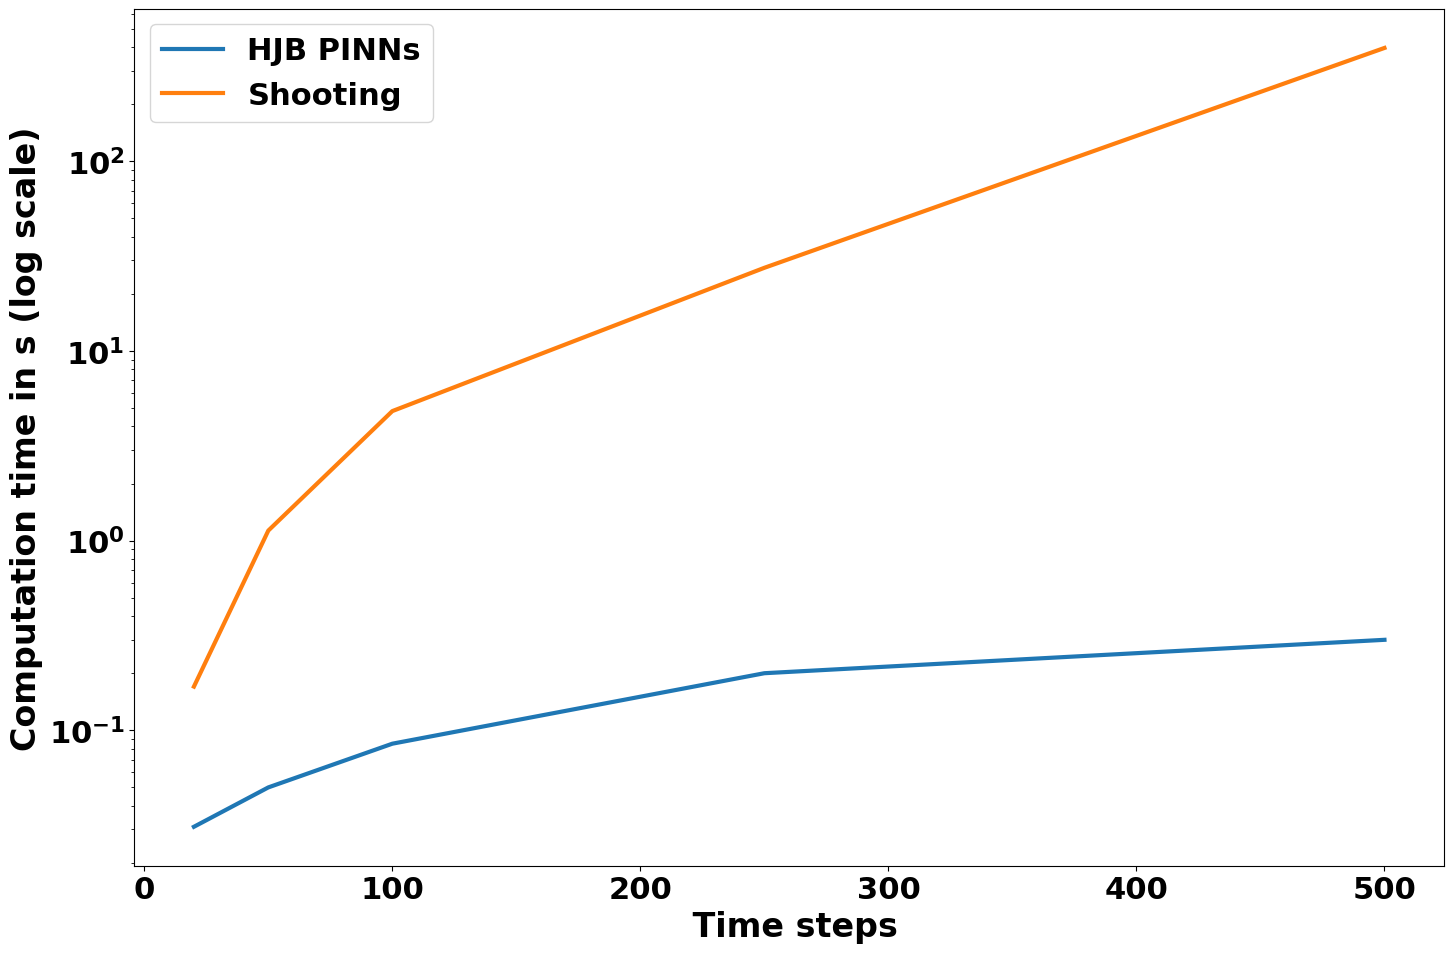

In [64]:
steps = np.array([20, 50, 100, 250, 500])
tim_h = np.array([0.031, 0.05, 0.085, 0.2 ,0.3 ])
tim_s = np.array([0.17, 1.13 , 4.82, 27.45 , 396 ])

font = { 'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,10))

plt.plot(steps, tim_h,  linewidth=3)
plt.plot(steps, tim_s, linewidth=3)
plt.legend(['HJB PINNs','Shooting'])
plt.xlabel(' Time steps', fontsize=24, fontweight = 'bold')
plt.ylabel('Computation time in s (log scale)', fontsize=24, fontweight = 'bold')
plt.yscale('log')

plt.tight_layout()
plt.savefig("time comparison.png", dpi = 200)
